<a href="https://colab.research.google.com/github/azhgh22/Comparative-analysis-of-Generative-models-on-CIFAR-10/blob/main/experiments/eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Env**

In [1]:
%%capture
from google.colab import drive
drive.mount('/content/drive')

from google.colab import userdata
token = userdata.get('GITHUB_TOKEN')
user_name = userdata.get('GITHUB_USERNAME')
mail = userdata.get('GITHUB_MAIL')

!git config --global user.name "{user_name}"
!git config --global user.email "{mail}"
!git clone https://{token}@github.com/azhgh22/Comparative-analysis-of-Generative-models-on-CIFAR-10.git
!pip install -r ./Comparative-analysis-of-Generative-models-on-CIFAR-10/requirements.txt

# **Import**

In [89]:
# Imports
import wandb
import sys
import os
import torch
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Add the root directory of the cloned repository to the Python path
sys.path.append('/content/Comparative-analysis-of-Generative-models-on-CIFAR-10')

import importlib
import data.cifar10 as cifar10_module
import utils.checkpointer as checkpointer_module
import train.train as train_module
import models.VAE_models.conv_vae as conv_vae_module
import samplers.vae_sampler as vae_sampler_module
import utils.weight_init as weight_module
import models.VAE_models.vqvae as vqvae_module
import models.VAE_models.pixelcnn as pixelcnn_module
import models.VAE_models.mmdvae as mmdvae_module
import models.VAE_models.conv_vae_res as conv_vae_res_module
import evaluation.eval_functions as eval_module
importlib.reload(cifar10_module)
importlib.reload(checkpointer_module)
importlib.reload(train_module)
importlib.reload(conv_vae_module)
importlib.reload(vae_sampler_module)
importlib.reload(weight_module)
importlib.reload(vqvae_module)
importlib.reload(pixelcnn_module)
importlib.reload(mmdvae_module)
importlib.reload(conv_vae_res_module)
importlib.reload(eval_module)
from data.cifar10 import load_cifar10
from utils.checkpointer import Checkpointer
from train.train import Train
from models.VAE_models.conv_vae import ConvVAE
from samplers.vae_sampler import vae_sample
from utils.weight_init import WeightsInitializer
from models.VAE_models.vqvae import VQVAE
from models.VAE_models.pixelcnn import PixelCNN
from models.VAE_models.mmdvae import MMDVAE
from models.VAE_models.conv_vae_res import ConvVAERes
from evaluation.eval_functions import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


# **Load Cifar Data**

In [3]:
train_loader, test_loader = load_cifar10(batch_size=256)

100%|██████████| 170M/170M [00:03<00:00, 47.5MB/s]


In [4]:
import matplotlib.pyplot as plt
from torchvision import transforms

def show_img(img):
    if img.dim() == 4:
        img = img[0]

    img = img.detach().cpu().clamp(0, 1)
    img = img.permute(1, 2, 0)  # CHW -> HWC

    h, w, _ = img.shape
    dpi = 100  # matplotlib default

    # plt.figure(figsize=(w / dpi, h / dpi), dpi=dpi)
    # plt.imshow(img, interpolation='none')  # <- critical

    plt.figure(figsize=(2, 2))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.show()

# **Eval Mmd**

In [90]:
%%capture
model = MMDVAE().to(device)
model.apply(WeightsInitializer())

In [91]:
checkpoint_dir = "/content/drive/MyDrive/checkpoints_final/MmdVae"
checkpointer = Checkpointer(checkpoint_dir,"MmdVae",1,False)
train = Train(model,32,train_loader,checkpointer,device)
train.load_checkpoint()
# train.train()

Loaded latest checkpoint: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_200.pt


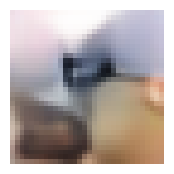

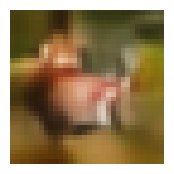

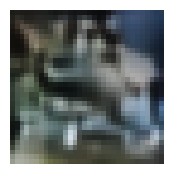

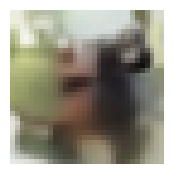

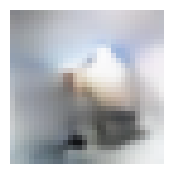

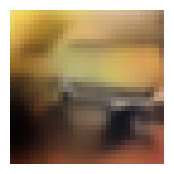

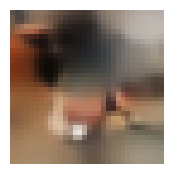

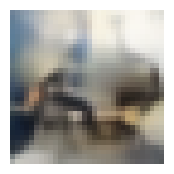

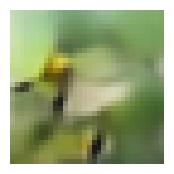

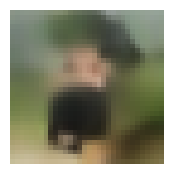

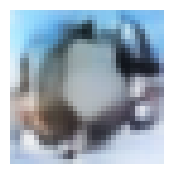

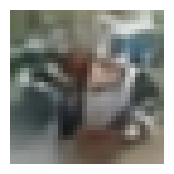

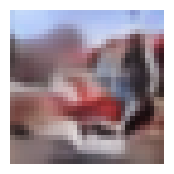

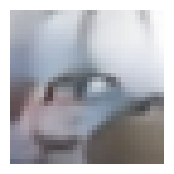

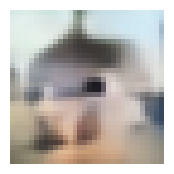

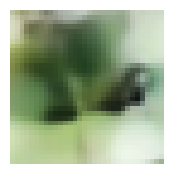

In [ ]:
images = model.sample(16)
for img in images:
  show_img(img)

In [92]:
train_dataset = train_loader.dataset
def reconstruct_samples(n_samples):
  images = []
  for i in range(1,1+n_samples):
    x_recon, _, _, _ = model(torch.unsqueeze(train_dataset[i][0].to(device),0))
    x_recon = x_recon.detach().cpu()
    x_real = train_dataset[i][0]
    images.append(torch.cat([x_real, x_recon[0]], dim=2))

  return images

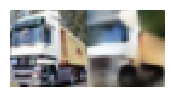

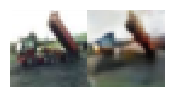

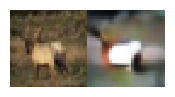

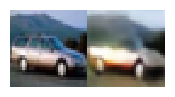

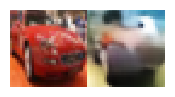

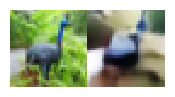

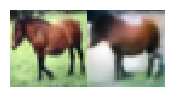

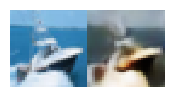

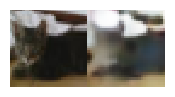

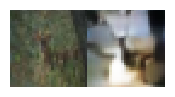

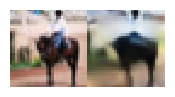

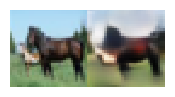

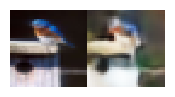

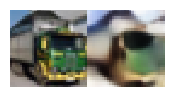

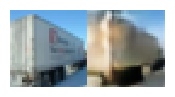

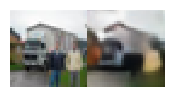

In [76]:
recon_images = reconstruct_samples(16)
for img in recon_images:
  show_img(img)

In [93]:
def compute_all(epoch):
  train.load_checkpoint(epoch)
  images = model.sample(16)
  reconstructed_images = reconstruct_samples(16)
  fid = compute_fid(test_loader,model,device)
  IS = compute_is(model,device)
  mi = compute_mi(model,test_loader,device)

  return {
              "epoch" : epoch,
              "samples" : images,
              "recon" : reconstructed_images,
              "fid" : fid,
              "is" : IS,
              "mi" : mi
        }

In [96]:
epoch_data = []

print("epoch 1")
data = compute_all(1)
print(f"epoch {1}")
print(f"fid {data["fid"]}")
print(f"fid {data["is"]}")
print(f"fid {data["mi"]}")
epoch_data.append(data);

for epoch in range(10,201,10):
  print(f"epoch {epoch}")
  data = compute_all(epoch)
  print(f"fid {data["fid"]}")
  print(f"fid {data["is"]}")
  print(f"fid {data["mi"]}")
  epoch_data.append(data)


epoch 1
Loaded checkpoint for epoch 1: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_1.pt


/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


epoch 1
fid 193.0582275390625
fid (2.004354476928711, 0.03945721313357353)
fid 5.540735244750977
epoch 10
Loaded checkpoint for epoch 10: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_10.pt
fid 161.0345458984375
fid (3.126410722732544, 0.08604442328214645)
fid 5.540729522705078
epoch 20
Loaded checkpoint for epoch 20: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_20.pt
fid 155.55258178710938
fid (3.1891133785247803, 0.06303663551807404)
fid 5.540729522705078
epoch 30
Loaded checkpoint for epoch 30: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_30.pt
fid 149.71556091308594
fid (3.37019419670105, 0.04993749409914017)
fid 5.540729522705078
epoch 40
Loaded checkpoint for epoch 40: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_40.pt
fid 143.1383514404297
fid (3.511489152908325, 0.08744791895151138)
fid 5.540729522705078
epoch 50
Loaded checkpoint for epoch 50: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_50.pt
fid 1

In [101]:
epoch_data[1]["is"][0]

3.126410722732544

# **Upload to Wandb**

In [97]:
!wandb login

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: azhgh22 (GenBeasts) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [102]:
CONFIG = {
    "Name" : "MmdVae",
    "epochs": 200,
    "batch_size": 128,
    "learning_rate": 0.0001,
    "optimizer_beta1": 0.5,
    "optimizer_beta2": 0.999,
    "img_pool_size" : 50,
    "lambda_cycle" : 10,
    "lambda_identity" : 5,
    "resonstruction loss" : "MSELoss",
    "Kl loss" : "MMD"
}

wandb.init(project="Comparative-analysis-of-Generative-models-on-CIFAR-10", entity="GenBeasts", name="MmdVae", config=CONFIG)

try:
    for i in range(len(epoch_data)):
      data = epoch_data[i]
      epoch = data["epoch"]
      generated = data["samples"]
      reconstructed = data["recon"]

      fid = data["fid"]
      IS = data["is"][0]
      mi = data["mi"]

      train.load_checkpoint(epoch)

      losses = train.epoch_losses[-1]

      metrics_to_log = {
          "FID" : fid,
          "IS" : IS,
          "MI" : mi,
          **losses
        }
      print(f"Logging metrics for epoch {epoch}: {metrics_to_log}") # Debugging print
      wandb.log(metrics_to_log, step=epoch)

      for idx in range(len(generated)):
          print(f"Logging images for epoch {epoch}, idx {idx}") # Debugging print
          wandb.log({
              f"Generated Samples{idx}": wandb.Image(generated[idx], caption=f"Epoch {epoch} Generated {idx}"),
            }, step=epoch)

          wandb.log({
              f"recon images{idx}": wandb.Image(reconstructed[idx], caption=f"Epoch {epoch} Reconstructed {idx}"),
            }, step=epoch)

      model_states = model.state_dict()
      # Save and log monet_generator state dict as a model artifact
      torch.save(model_states, f"{CONFIG['Name']}_{epoch}.pt")
      model_artifact = wandb.Artifact(f"{CONFIG['Name']}", type="model")
      model_artifact.add_file(f"{CONFIG['Name']}_{epoch}.pt")
      print(f"Logging monet_generator artifact for epoch {epoch}") # Debugging print
      wandb.log_artifact(model_artifact, aliases=["latest", f"epoch_{epoch}"])
      os.remove(f"{CONFIG['Name']}_{epoch}.pt") # Clean up local file
finally:
  print("Ensuring wandb.finish() is called.")
  wandb.finish()



Loaded checkpoint for epoch 1: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_1.pt
Logging metrics for epoch 1: {'FID': 193.0582275390625, 'IS': 2.004354476928711, 'MI': 5.540735244750977, 'loss': 64.24011242146395, 'recon': 60.08452919551304, 'mmd': 0.041555829783331374}
Logging images for epoch 1, idx 0
Logging images for epoch 1, idx 1
Logging images for epoch 1, idx 2
Logging images for epoch 1, idx 3
Logging images for epoch 1, idx 4
Logging images for epoch 1, idx 5
Logging images for epoch 1, idx 6
Logging images for epoch 1, idx 7
Logging images for epoch 1, idx 8
Logging images for epoch 1, idx 9
Logging images for epoch 1, idx 10
Logging images for epoch 1, idx 11
Logging images for epoch 1, idx 12
Logging images for epoch 1, idx 13
Logging images for epoch 1, idx 14
Logging images for epoch 1, idx 15
Logging monet_generator artifact for epoch 1
Loaded checkpoint for epoch 10: /content/drive/MyDrive/checkpoints_final/MmdVae/MmdVae_epoch_10.pt
Logging metrics for

FID,█▅▅▄▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
IS,▁▅▅▆▆▆▇▇▇▇▇▇▇████████
MI,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mmd,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recon,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
FID,116.29294
IS,4.10528
MI,5.54073
loss,7.63949
mmd,0.00092
